## Overview of `pylabianca`
This notebook offers a relatively short overview of the `pylabianca` package.
It is not meant to be a comprehensive tutorial, but rather a quick overview of
some of the functionality.

In [15]:
import os
import os.path as op

import numpy as np

Set up paths to the data, residing on OneDrive in BIDS format. You need to have
OneDrive installed on your computer and synced with the cloud. Below,
`sarna` package is used to locate the OneDrive folder.


In [2]:
import sarna

onedrive_dir = sarna.proj.find_onedrive(kind='business')

superdual_dir = op.join(onedrive_dir, 'RESEARCH', 'superdual')
beh_data_dir = op.join(superdual_dir, r'sourcedata\sub-U10\ses-main\beh')
raw_data_dir = op.join(superdual_dir, r'sub-U10\ses-main\ieeg',
                       'sub-U10_ses-main_task-superdual_run-01_ieeg')
spike_data_dir = op.join(superdual_dir, 'derivatives\example\sub-U10',
                         r'osorted\mixed\5')

The spiking data we use here have not been curated, so there may be some
false positive units and duplicates (due to reference signal). The files used here are only from Medial Temporal Lobe contacts, but still, including
waveforms the files take around 2 GB.

In [3]:
os.listdir(spike_data_dir)[:10]

['A153_sorted_new.mat',
 'A154_sorted_new.mat',
 'A155_sorted_new.mat',
 'A156_sorted_new.mat',
 'A157_sorted_new.mat',
 'A158_sorted_new.mat',
 'A159_sorted_new.mat',
 'A160_sorted_new.mat',
 'A161_sorted_new.mat',
 'A162_sorted_new.mat']

We can read the whole directory of osort files using `pylabianca.io.read_osort`. This function can read data files saved either in the standard osort or "mm" formats. The data we use here have not been curated and re-exported, so they are in the standard osort format. Aparat from spike data we will also read the waveforms for all the units. Note that reading waveforms is around 90% of reading time, so it slows down the reading to 5 - 10 seconds.

In [4]:
import pylabianca as pln

spk = pln.io.read_osort(spike_data_dir, waveform=True, format='standard')

100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


The `spk` variable we got is a `pylabianca.Spikes` object:

In [5]:
spk

<Spikes, 347 cells, 966.6 spikes/cell on average>

We will not discuss the internal structure of the `Spikes` object here, as we will mostly work on epoched data (and thus `SpikeEpochs` object will be used). But we'll plot a wavefrom density plot for one example unit, just to show that it is simple (you can change the value of the `pick` argument to see waveforms for other units):

<AxesSubplot:xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>

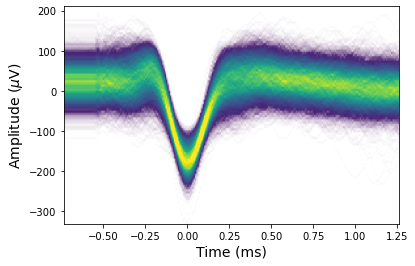

In [6]:
spk.plot_waveform(pick=6)

We can also perform some additional upsampling of the waveform (on top of default osort upsampling):

<AxesSubplot:xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>

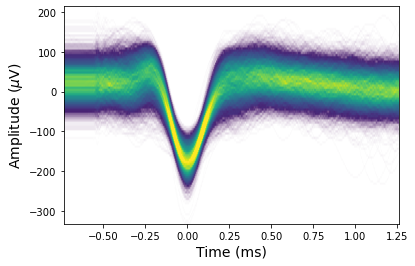

In [7]:
spk.plot_waveform(pick=6, upsample=3)

Before moving further we will perform a simple cells selection. We will remove any units that have less than 250 spikes recorded:

In [8]:
min_spikes = 250
sel = spk.n_spikes() >= min_spikes

spk.pick_cells(sel)

<Spikes, 175 cells, 1786.4 spikes/cell on average>

From initial 347 units we are now left with 175.  
Note that `.pick_cells()` method works in place and our original object is modified now (to work on a copy use `spk_sel = spk.copy().pick_cells(sel)`):

In [9]:
spk

<Spikes, 175 cells, 1786.4 spikes/cell on average>

### Reading events and epoching data

We now want to epoch the data with respect to image presentation. For this we will have to read the events from the raw NCS directory. We could also read `events.tsv` in BIDS format, but we will not do it here.  
  
Reading raw Neuralynx files requires NeuralynxIO package (at least for now), you can get it from github:  
[link](https://github.com/alafuzof/NeuralynxIO)  
we will make sure it is on `PYTHONPATH` so that it imports without problems.

In [10]:
import sys

sys.path.append(r'C:\src\NeuralynxIO')

NeuralynxIO is not very fast and throws a lot of warnings for the new ATLAS files, but we will live with it for now. We ask for `format='mne'` to get a n_events x 3 array instead of a dataframe.

In [12]:
events = pln.io.read_neuralynx_events(raw_data_dir, format='mne')

C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:78: UserWarning: Unable to parse original file path from Neuralynx header: -FileType Event
  warnings.warn('Unable to parse original file path from Neuralynx header: ' + hdr_lines[1])
C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:130: UserWarning: Unable to parse time string from Neuralynx header: -FileVersion 3.2
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:130: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 7fcbbbef-7031-4885-993f-6166c3448912
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:92: UserWarning: Unable to parse parameter line from Neuralynx header: -OriginalFileName D:\U10\20221117\superdual 2\2022-11-17_15-51-42\Events.nev
  warnings.warn('Unable to parse parameter line from Neuralynx header: ' + line)
C:\src\NeuralynxIO\neur

Let's take a look at how the events are represented:

In [13]:
events[:10]

array([[1668700445811391,                0,              100],
       [1668700446827047,                0,              130],
       [1668700453721231,                0,              241],
       [1668700456008480,                0,              100],
       [1668700457507542,                0,              130],
       [1668700459615010,                0,              242],
       [1668700461069416,                0,              100],
       [1668700462563384,                0,              130],
       [1668700464336665,                0,              241],
       [1668700465843851,                0,              100]],
      dtype=int64)

The events are read in mne-python compatible format: the first column is the timestamp, while the last one is the trigger value.  
In superdual the images are represented by trigger values `110 + image_index`, so these are: 110, 111, and 112.  
Additionally, because multiple parts of the experiment are recorded in the same file, we have to filter out the events that are not related to the superdual task. We will do it by selecting only events before last `152` trigger (this trigger value informs about start of each experiment part).

In [16]:
event_id = [110, 111, 112]
last_part_start = np.where(events[:, -1] == 152)[0][-1]
use_events = events[:last_part_start]

We can now epoch spikes using `.epoch()` method of the `Spikes` object. We will epoch spikes with respect to image presentation, with 0.5 second pre-stimulus and 1 second post-stimulus window.

In [17]:
spk_epochs = spk.epoch(use_events, event_id, tmin=-0.5, tmax=2.)

Let's take a look at the text representation of the resulting `SpikeEpochs` object:

In [18]:
spk_epochs

<SpikeEpochs, 80 epochs, 175 cells, 108.4 spikes/cell on average>

### Computing and visualizing spike rate

Using `.spike_rate()` or `.spike_density()` methods we can compute spike rate or spike density for each unit and each epoch. The resulting object is an xarray `DataArray`:

In [19]:
frate = spk_epochs.spike_rate(winlen=0.5)

Plotting `frate` object is easy, it has a `plot()` method (below we also select fifth cell to plot - the one with index `4`):

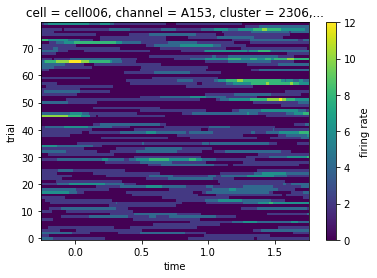

In [27]:
frate.isel(cell=4).plot()

To average the trial dimension we can use `.mean(dim='trial')`:

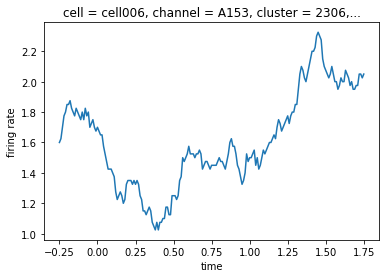

In [28]:
frate.isel(cell=4).mean(dim='trial').plot()

The only disadvantage of native xarray plotting is that it is unable to plot error intervals. We can use `pylabianca.viz.plot_spike_rate` to plot the spike rate with standard error of the mean:

<AxesSubplot:title={'center':'Firing rate'}, xlabel='Time (s)', ylabel='Spike rate (Hz)'>

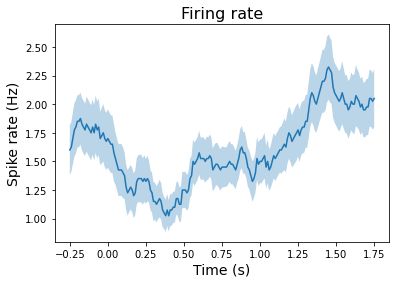

In [29]:
pln.viz.plot_spike_rate(frate.isel(cell=4))

Let's compare this to the spike density plot:

<AxesSubplot:title={'center':'Firing rate'}, xlabel='Time (s)', ylabel='Spike rate (Hz)'>

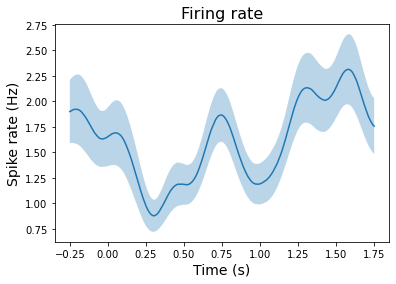

In [32]:
fdens = spk_epochs.spike_density(winlen=0.5, picks=4)
pln.viz.plot_spike_rate(fdens)

spike density has a different weighting profile than spike rate: by convlving the spikes with a gaussian, not a rectangular window, it gives a better resolution trade-off and a smoother time course.
To see the raster plot you can use `plot_raster()` function:


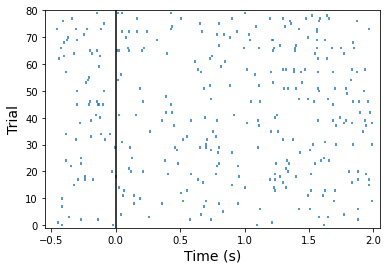

In [42]:
ax = pln.viz.plot_raster(spk_epochs, pick=4)
ax.axvline(x=0, color='k', lw=1.5)

To see both average spike rate and raseter plot in one figure, you can use `plot_spikes` function:

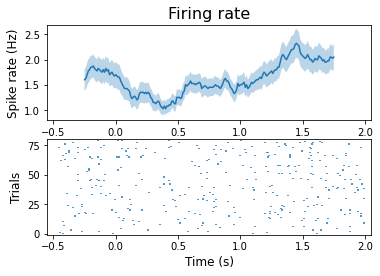

In [46]:
pln.viz.plot_spikes(spk_epochs, frate, pick=4);

### Splitting by condition
However, to get the most out of xarray or pylabianca plotting it is good to have condition information in the `SpikeEpochs` object. We can add a dataframe of experimental information to `.metadata` attribute. We will construct the dataframe from trigger values here, but you can use a rich dataframe output by your experiment.

In [48]:
import pandas as pd

is_img = np.in1d(use_events[:, -1], event_id)
image = use_events[is_img, -1] - 110
meta = pd.DataFrame({'image': image})

meta.head()

,image
0,1
1,2
2,1
3,0
4,2


In [50]:
spk_epochs.metadata = meta


Now, after recalculating firing rate again, we can use the `'image'` column in plotting operations:

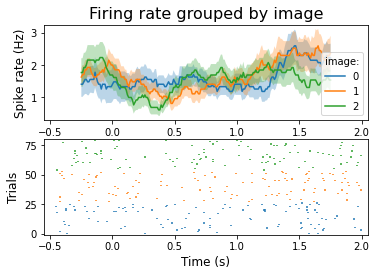

In [51]:
frate = spk_epochs.spike_rate(winlen=0.5)

pln.viz.plot_spikes(spk_epochs, frate, pick=4, groupby='image');

This cell does not seem to be image selective, let's find image selective cells using cluster based permutation test:

# TBC